# Study of connectivity matrix
In this notebook we study the effects of the following parameters in the connectivity paramters:
* tau_z 
* tau_p
* training_time
* inter sequence interval time
* adaptation time
* tau_m (?)

In particular we are concerned about the following variables (in terms of the artificial matrix)
* Excitation
* Inhibition
* Extension
* Sequence Decay
* Extension Decay

In [9]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [10]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '61b730afc40a2a0933454b69ac8ca67b63ba95e7'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

In [11]:
from network import Protocol, BCPNNFast, NetworkManager
from plotting_functions import plot_weight_matrix
from analysis_functions import calculate_recall_success, calculate_timings

## A simple example

In [12]:
# Patterns parameters
hypercolumns = 4
minicolumns = 70
n_patterns = 60

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

n = 5
T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre)
manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
simple_protocol = Protocol()
simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                inter_sequence_interval=inter_sequence_interval)

In [13]:
manager.run_network_protocol(simple_protocol)
w_small = manager.nn.w[:minicolumns, :minicolumns]

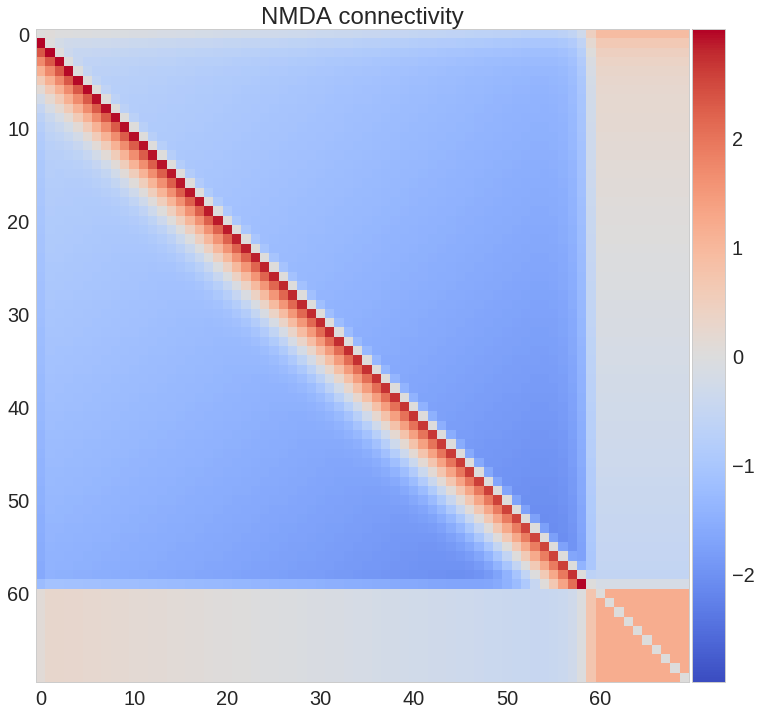

In [14]:
plot_weight_matrix(nn, one_hypercolum=True)

In [15]:
success = calculate_recall_success(manager, T_recall, I_cue=0, T_cue=T_cue, n=n, patterns_indexes=patterns_indexes)

In [16]:
timings = calculate_timings(manager)
for x in timings:
    print x[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


#### Now we need to define functions to calculate the desired quantities

In [17]:
print('success', success)

('success', 0.0)


First let's calculate intensity

In [18]:
next_connections = np.zeros(n_patterns - 1)
for i in range(n_patterns - 1):
    next_connections[i] =w_small[i + 1, i]

In [19]:
intensity = next_connections[0]
print(intensity)

2.99209435727


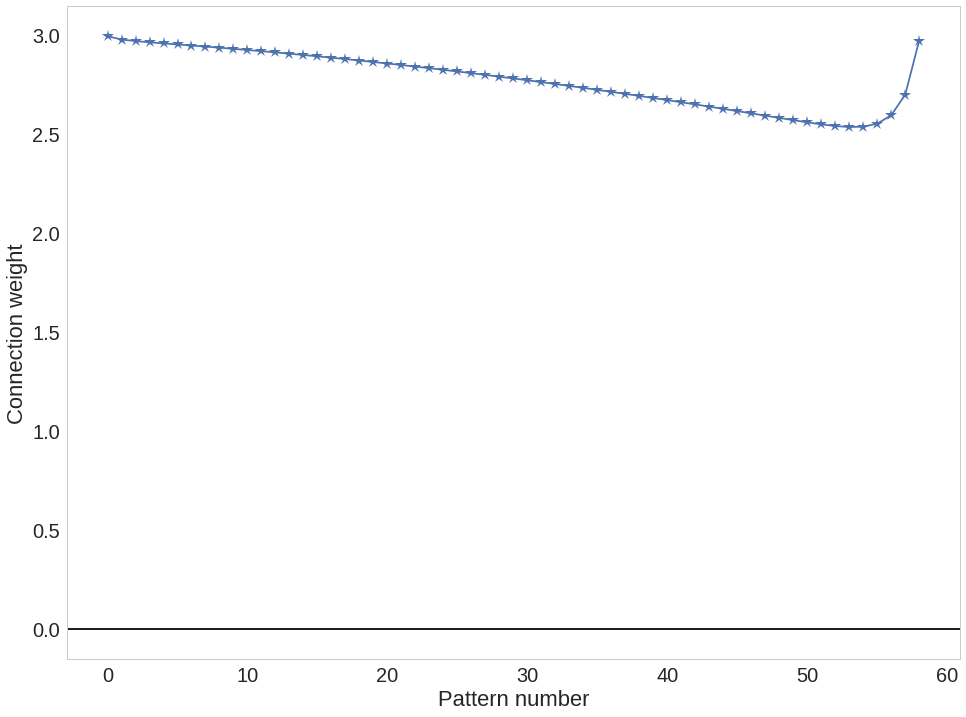

In [20]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(next_connections, '*-', markersize=13)
ax.axhline(0, color='k')

ax.set_xlabel('Pattern number')
ax.set_ylabel('Connection weight');


Let's calculate the ratios between them

In [21]:
sequence_ratios = np.zeros(n_patterns - 2)
for i in range(n_patterns - 2):
    sequence_ratios[i] = next_connections[i + 1] / next_connections[i]

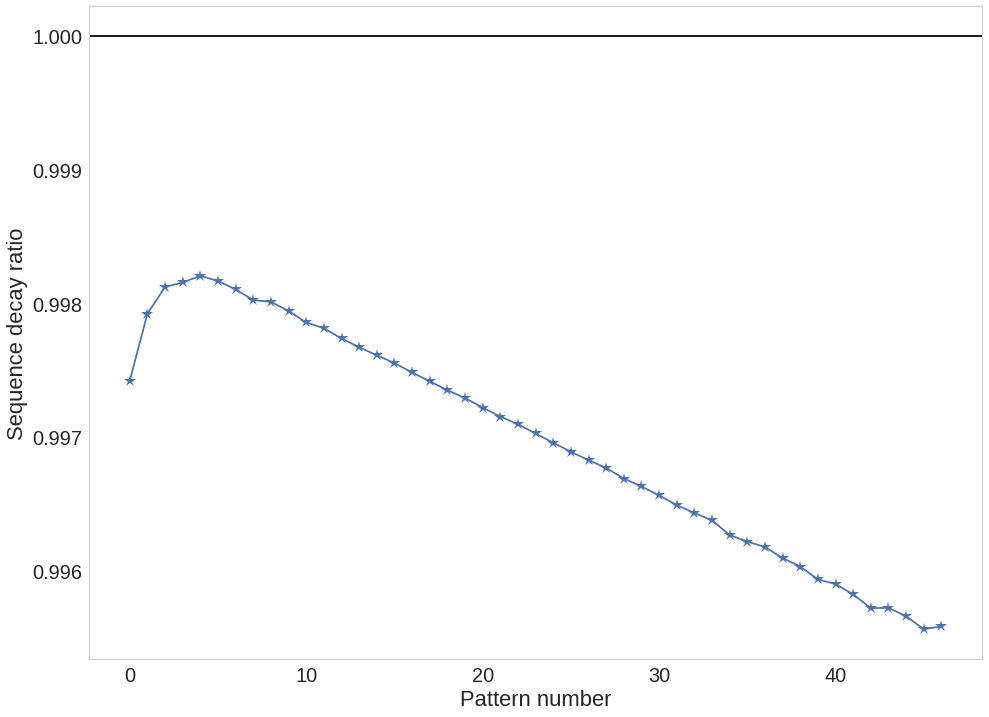

In [22]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(sequence_ratios[1:-10], '*-', markersize=13)
ax.axhline(1, color='k')

ax.set_xlabel('Pattern number')
ax.set_ylabel('Sequence decay ratio');

We can see the ratio is a little bit below 0.9. What we will do here is remove the first and the last five values and calculate the mean

In [23]:
sequence_decay = np.mean(sequence_ratios[1:-5])
print(sequence_decay)

0.996916242623


Let's pack this into a function

In [24]:
def calculate_intensity_and_decay(w_small):
    next_connections = np.zeros(n_patterns - 1)
    for i in range(n_patterns - 1):
        next_connections[i] =w_small[i + 1, i]
        
    intensity = next_connections[0]
    
    sequence_ratios = np.zeros(n_patterns - 2)
    for i in range(n_patterns - 2):
        sequence_ratios[i] = next_connections[i + 1] / next_connections[i]
        
    sequence_decay = np.mean(sequence_ratios[1:-5])
    
    return intensity, sequence_decay

In [25]:
intensity, sequence_decay = calculate_intensity_and_decay(w_small)
print(sequence_decay)
print(intensity)

0.996916242623
2.99209435727


Now let's calculate the extensions

In [26]:
extensions = []
weights = []
extensions_decay = []
tolerance = 5
total = n_patterns - 5
for i in range(tolerance, total):
    w_column = w_small[:n_patterns, i]
    w_column = w_column[w_column > 0]
    ratios = w_column[1:] / w_column[:-1]
    extensions_decay.append(np.mean(ratios))
    extensions.append(w_column.size)
    for w in w_column:
        weights.append(w)        

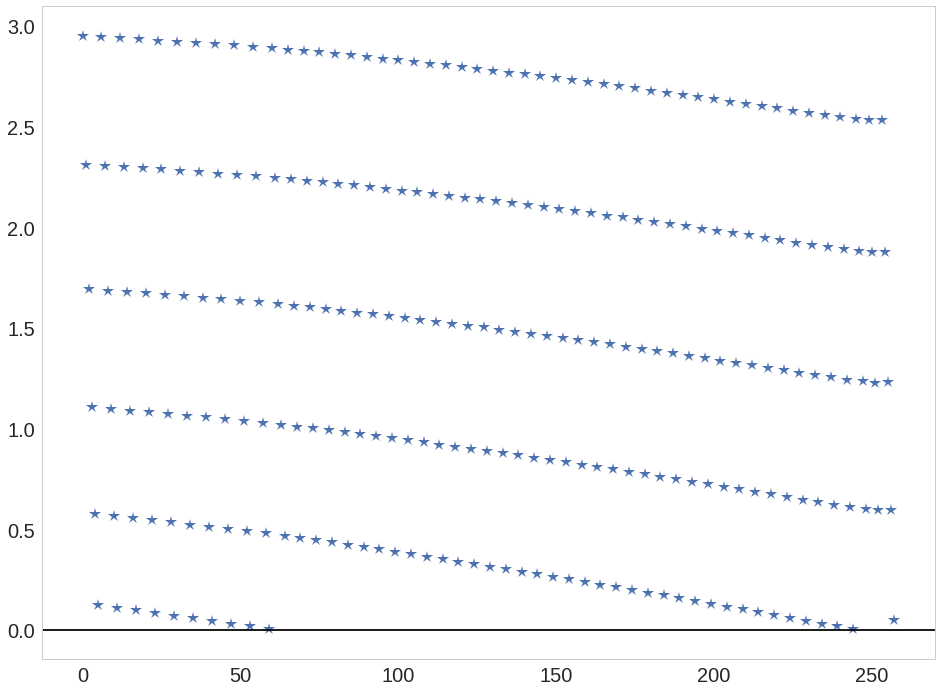

In [27]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(weights, '*', markersize=13);
ax.axhline(0, color='black')

In [28]:
extension_decay = np.median(extensions_decay)
print(extension_decay)

0.571691379686


In [29]:
extension = int(np.median(extensions))
print(extension)

5


Now we pack this into a function

In [30]:
def calculate_extensions(w_small, tolerance):
    extensions = []
    extensions_decay = []
    total = n_patterns - tolerance
    for i in range(tolerance, total):
        w_column = w_small[:n_patterns, i]
        w_column = w_column[w_column > 0]
        ratios = w_column[1:] / w_column[:-1]
        extensions_decay.append(np.mean(ratios))
        extensions.append(w_column.size)
    
    extension_decay = np.median(extensions_decay)
    extension = int(np.median(extensions))
    
    return extension, extension_decay

In [31]:
extension, extension_decay = calculate_extensions(w_small, tolerance=5)
print('extension', extension)
print('extension decay', extension_decay)

('extension', 5)
('extension decay', 0.57169137968574391)


Finally we need inhibition

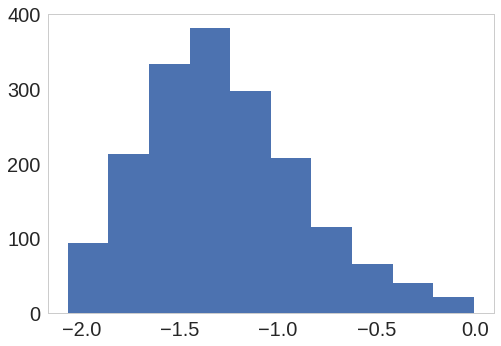

In [32]:
upper_indices = np.triu_indices(n_patterns)
w_upper = w_small[upper_indices]
w_upper = w_upper[w_upper < 0]
plt.hist(w_upper);

In [33]:
def calculate_inhibition(w_small):
    upper_indices = np.triu_indices(n_patterns)
    w_upper = w_small[upper_indices]
    w_upper = w_upper[w_upper < 0]
    
    mean = np.mean(w_upper)
    std = np.std(w_upper)
    
    return mean, std

In [34]:
mean, std = calculate_inhibition(w_small)
print('mean inhibition', mean)
print('std', std)

('mean inhibition', -1.2756921009402458)
('std', 0.40104953350080874)


## Training time
Let's calculate the dependence on this parameter

In [162]:
tolerance = 5

In [151]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

n = 5
T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

training_times_vector = np.arange(0.100, 1.100, 0.100)

In [35]:
def store_values(intensities, intensity, decays, decay, extensions, extension,
                 extension_decays, extension_decay, inhibitions, inhibition, inhibitions_std, inhibition_std):
    
    intensities.append(intensity)
    decays.append(decay)
    extensions.append(extension)
    extension_decays.append(extension_decay)
    inhibitions.append(inhibition)
    inhibitions_std.append(inhibition_std)
    

In [166]:
training_time_intensity = []
training_time_decay = []
training_time_extension = []
training_time_extension_decay = []
training_time_inhibition = []
training_time_inhibition_std = []

for training_times in training_times_vector:
    print(training_times)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(training_time_intensity, intensity, training_time_decay, sequence_decay, training_time_extension, 
                 extension, training_time_extension_decay, extension_decay, training_time_inhibition, inhibition,
                 training_time_inhibition_std, inhibition_std)
    

/home/heberto/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


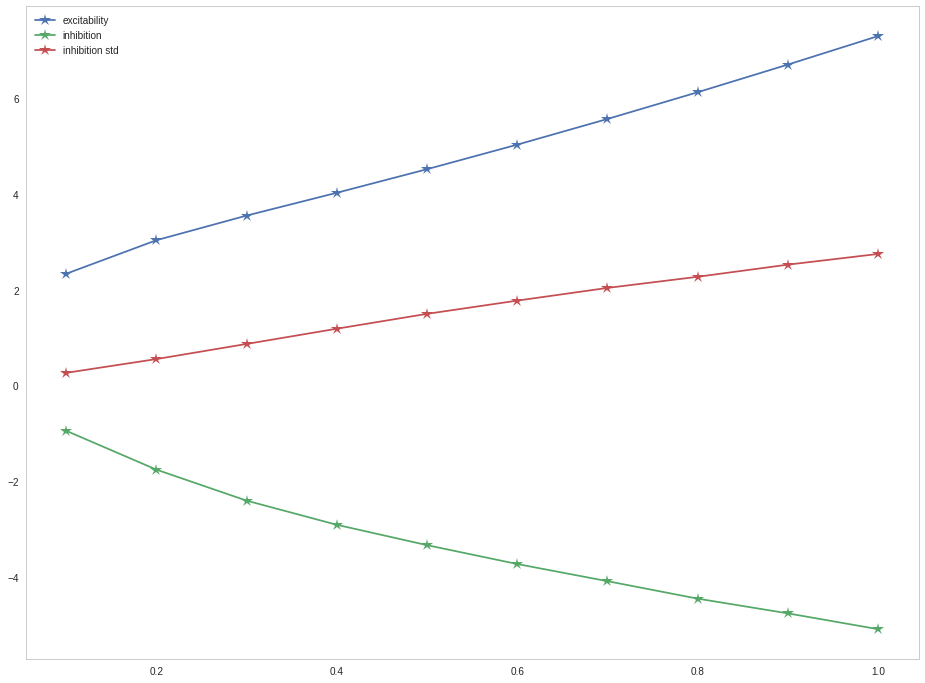

In [170]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_times_vector, training_time_intensity, '*-', markersize=13, label='excitability')
ax.plot(training_times_vector, training_time_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(training_times_vector, training_time_inhibition_std, '*-', markersize=13, label='inhibition std')

ax.legend();

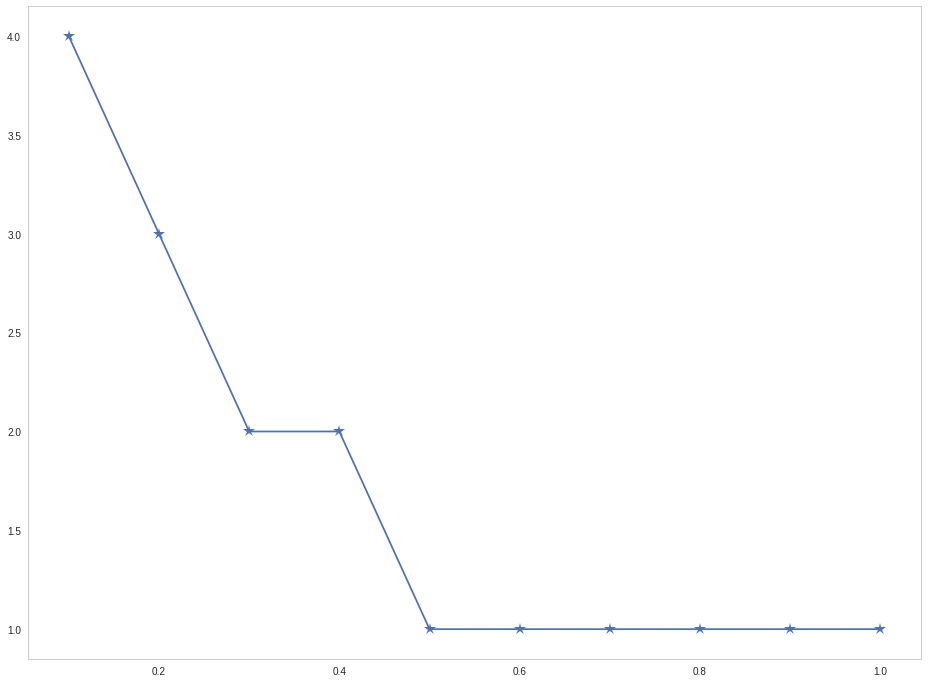

In [173]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_times_vector, training_time_extension, '*-', markersize=13, label='extension')

ax.axhline(0, color='k')

ax.set_ylabel('Extension')
ax.set_xlabel('Training time');

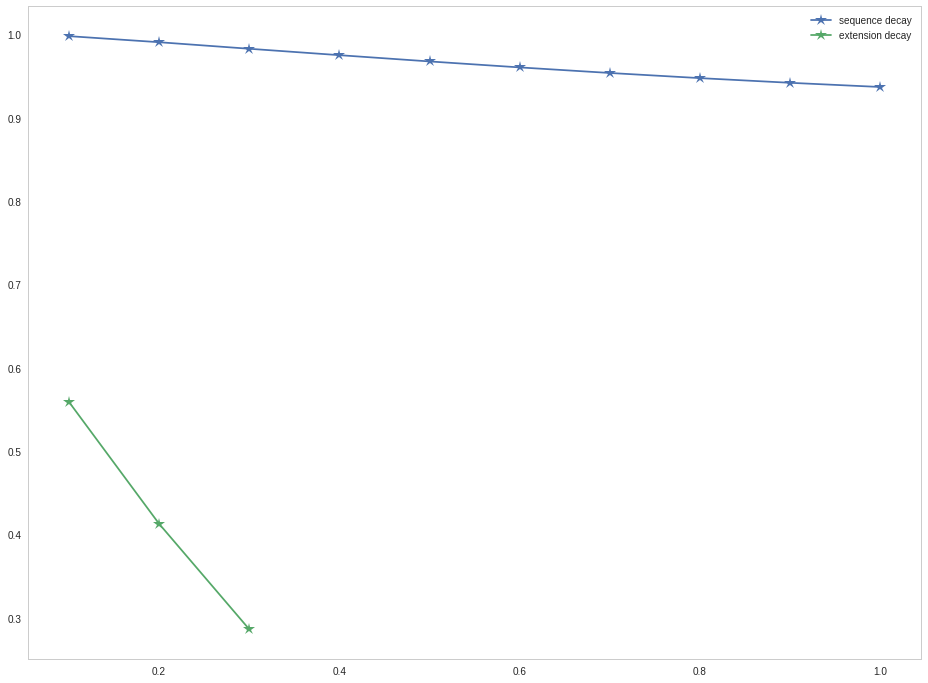

In [177]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_times_vector, training_time_decay, '*-', markersize=13, label='sequence decay')
ax.plot(training_times_vector, training_time_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')
ax.set_xlabel('Training time')
ax.set_ylabel('Factors')
ax.legend();

I do not understand the sequence decay here. Why it does increase with the training time? 

 

## Inter sequence time

In [178]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

n = 5
T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

inter_sequence_interval_vector = np.arange(0, 3.5, 0.5)

In [183]:
inter_sequence_intensity = []
inter_sequence_decay = []
inter_sequence_extension = []
inter_sequence_extension_decay = []
inter_sequence_inhibition = []
inter_sequence_inhibition_std = []

for inter_sequence_interval in inter_sequence_interval_vector:
    print(inter_sequence_interval)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol, verbose=False)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(inter_sequence_intensity, intensity, inter_sequence_decay, sequence_decay, inter_sequence_extension, 
                 extension, inter_sequence_extension_decay, extension_decay, inter_sequence_inhibition, inhibition,
                 inter_sequence_inhibition_std, inhibition_std)
    

0.0
0.5
1.0
1.5
2.0
2.5
3.0


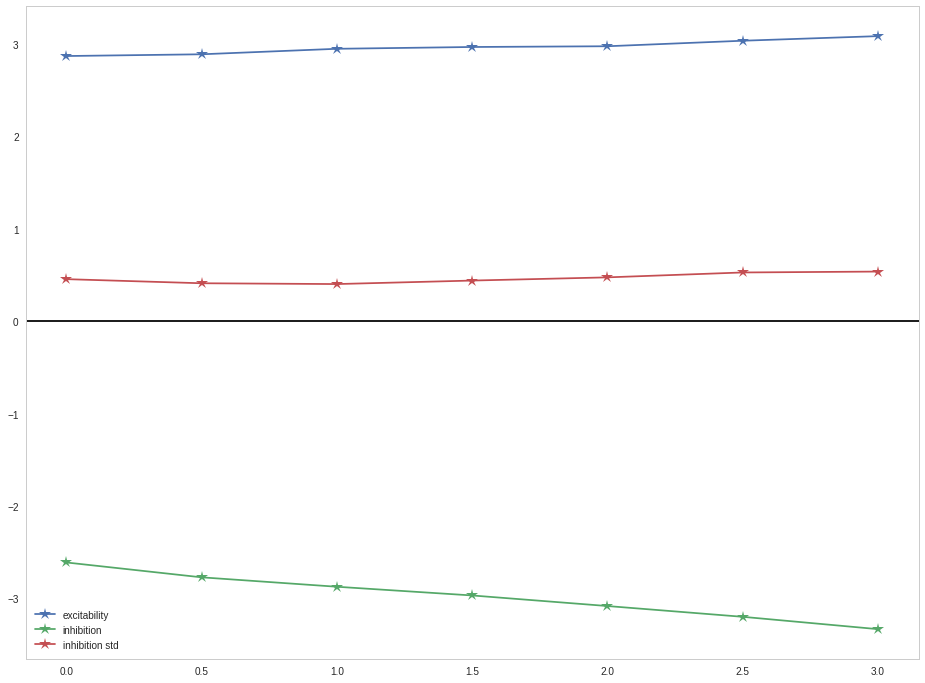

In [186]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_sequence_interval_vector, inter_sequence_intensity, '*-', markersize=13, label='excitability')
ax.plot(inter_sequence_interval_vector, inter_sequence_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(inter_sequence_interval_vector, inter_sequence_inhibition_std, '*-', markersize=13, label='inhibition std')
ax.axhline(0, color='k')

ax.legend();

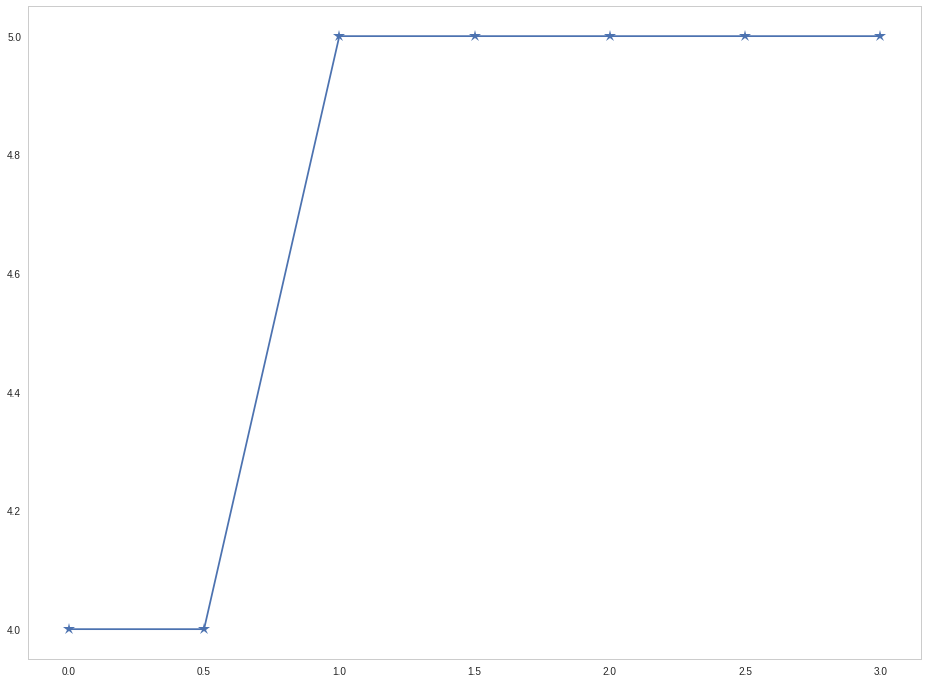

In [187]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_sequence_interval_vector, inter_sequence_extension, '*-', markersize=13, label='extension')

ax.axhline(0, color='k')
ax.set_xlabel('Inter sequnce time');

This is **interesting** why?

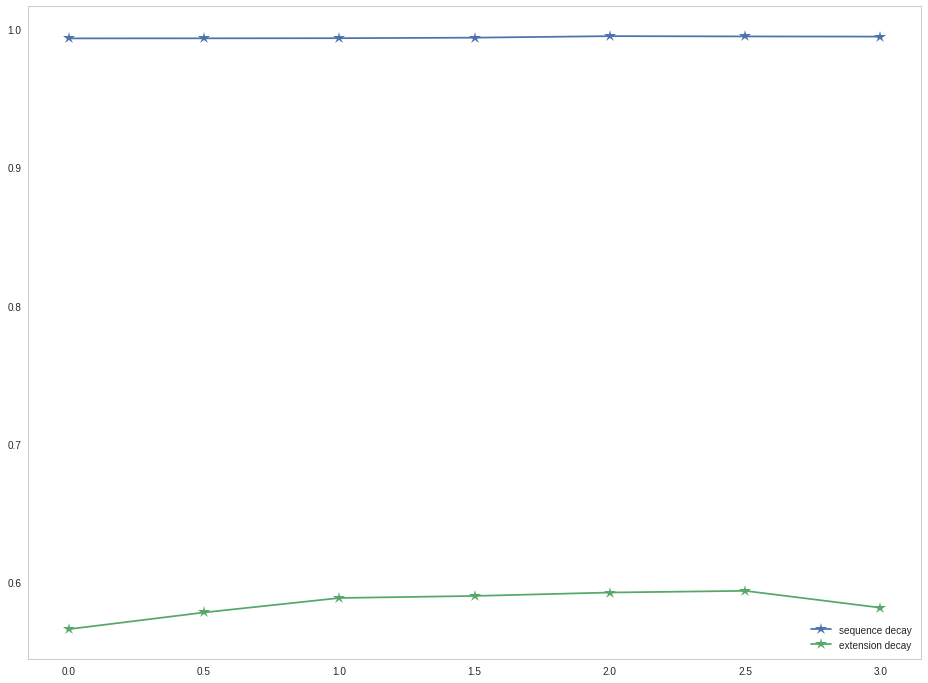

In [188]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_sequence_interval_vector, inter_sequence_decay, '*-', markersize=13, label='sequence decay')
ax.plot(inter_sequence_interval_vector, inter_sequence_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')
ax.legend();

## Epoch

In [200]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

n = 5
T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

epochs_vector = np.arange(1, 10, 1, dtype='int')

In [201]:
epochs_intensity = []
epochs_sequence_decay = []
epochs_extension = []
epochs_extension_decay = []
epochs_inhibition = []
epochs_inhibition_std = []

for epochs in epochs_vector:
    print(epochs)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol, verbose=False)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(epochs_intensity, intensity, epochs_sequence_decay, sequence_decay, epochs_extension, 
                 extension, epochs_extension_decay, extension_decay, epochs_inhibition, inhibition,
                 epochs_inhibition_std, inhibition_std)
    

1
3
5
7
9


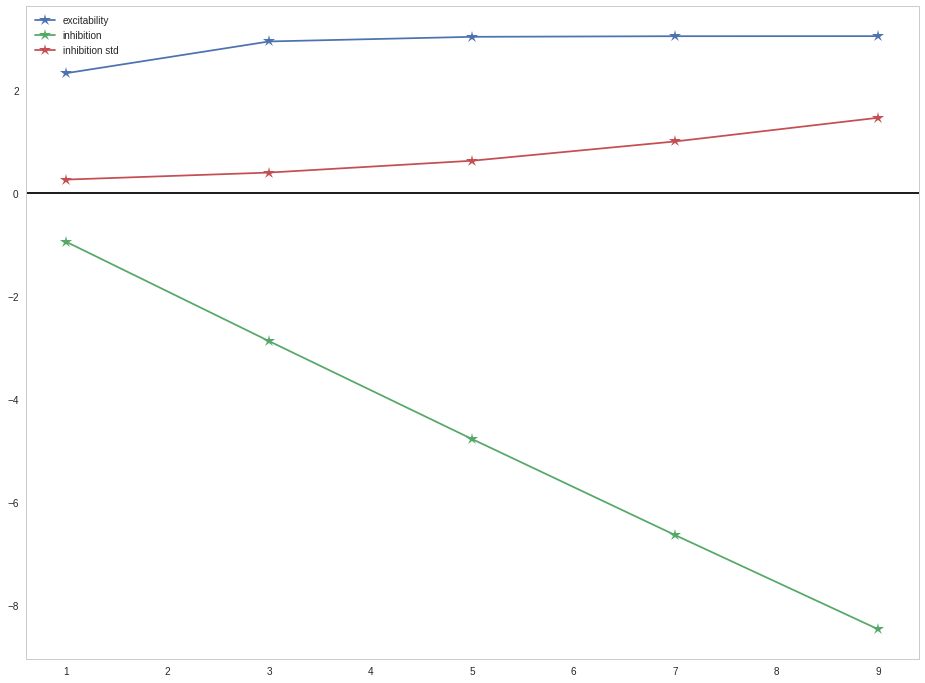

In [202]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(epochs_vector, epochs_intensity, '*-', markersize=13, label='excitability')
ax.plot(epochs_vector, epochs_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(epochs_vector, epochs_inhibition_std, '*-', markersize=13, label='inhibition std')
ax.axhline(0, color='k')

ax.legend();

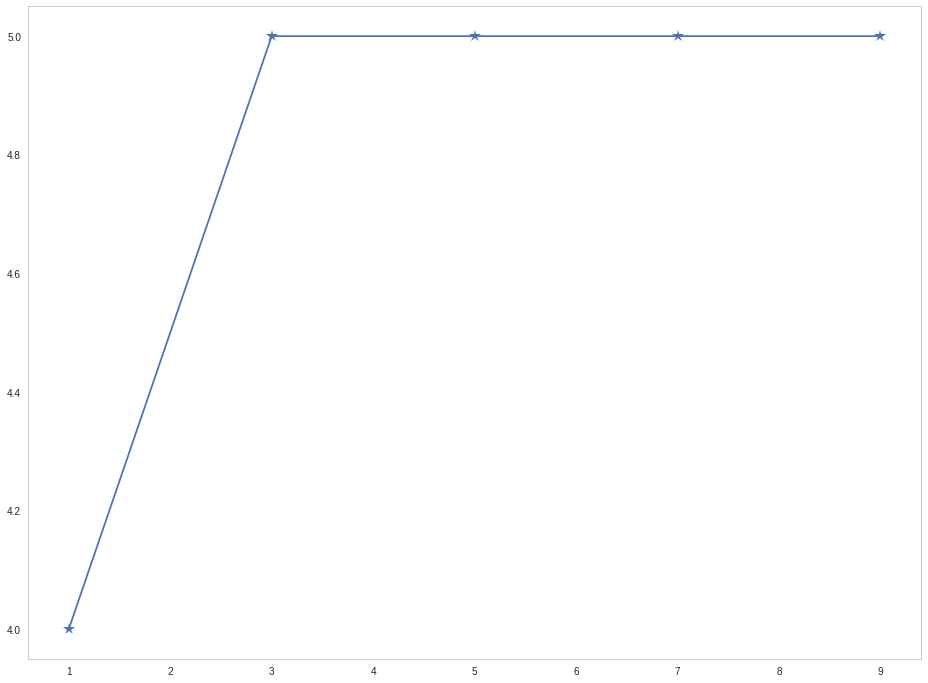

In [203]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(epochs_vector, epochs_extension, '*-', markersize=13, label='extension')

ax.axhline(0, color='k');

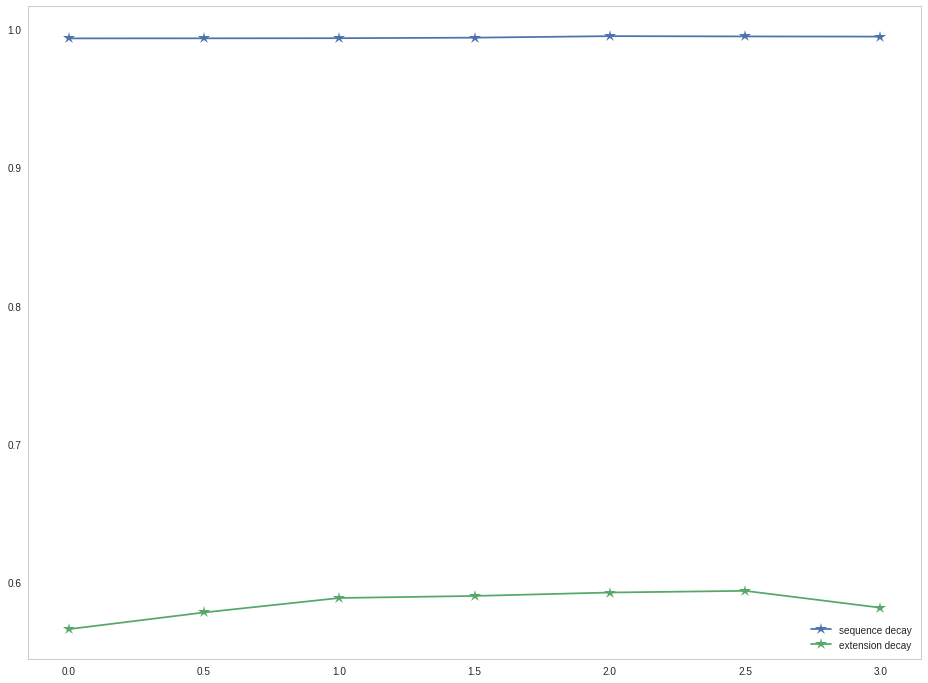

In [204]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_sequence_interval_vector, inter_sequence_decay, '*-', markersize=13, label='sequence decay')
ax.plot(inter_sequence_interval_vector, inter_sequence_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')
ax.legend();

## tau_z

In [209]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

tau_z_pre_vector = np.arange(0.050, 0.550,0.050)

In [210]:
tau_z_intensity = []
tau_z_sequence_decay = []
tau_z_extension = []
tau_z_extension_decay = []
tau_z_inhibition = []
tau_z_inhibition_std = []

for tau_z_pre in tau_z_pre_vector:
    print(tau_z_pre)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol, verbose=False)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(tau_z_intensity, intensity, tau_z_sequence_decay, sequence_decay, tau_z_extension, 
                 extension, tau_z_extension_decay, extension_decay, tau_z_inhibition, inhibition,
                 tau_z_inhibition_std, inhibition_std)
    

0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5


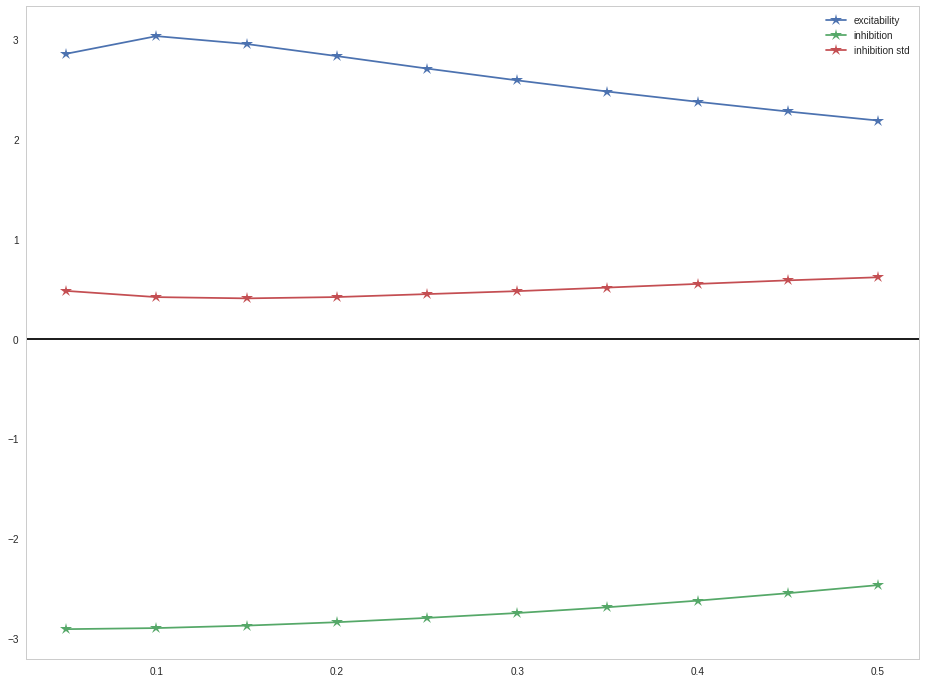

In [213]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_z_pre_vector, tau_z_intensity, '*-', markersize=13, label='excitability')
ax.plot(tau_z_pre_vector, tau_z_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(tau_z_pre_vector, tau_z_inhibition_std, '*-', markersize=13, label='inhibition std')
ax.axhline(0, color='k')

ax.legend();

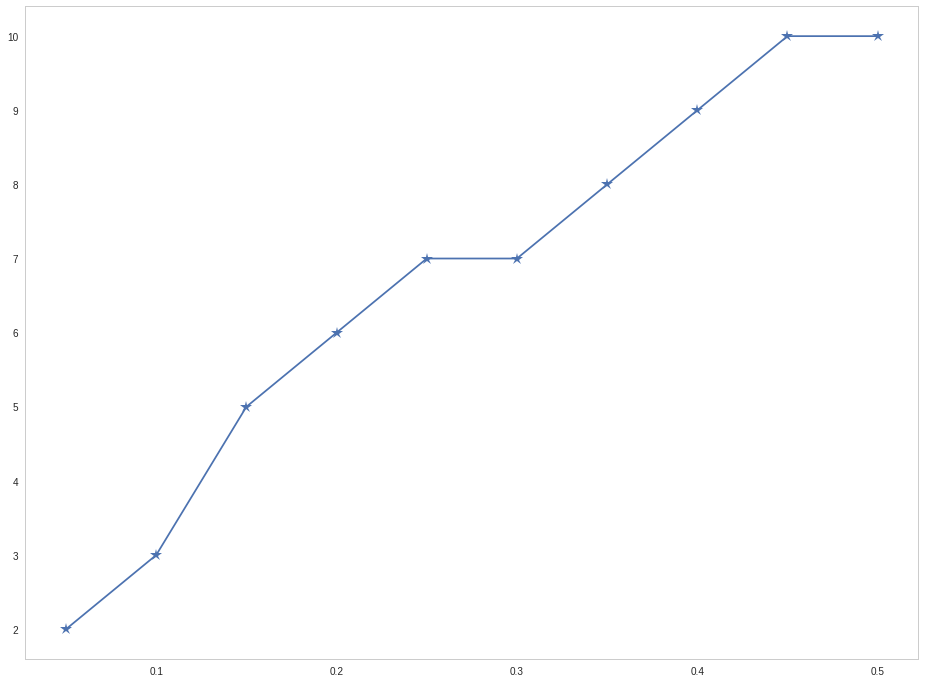

In [214]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_z_pre_vector, tau_z_extension, '*-', markersize=13, label='extension')

ax.axhline(0, color='k');

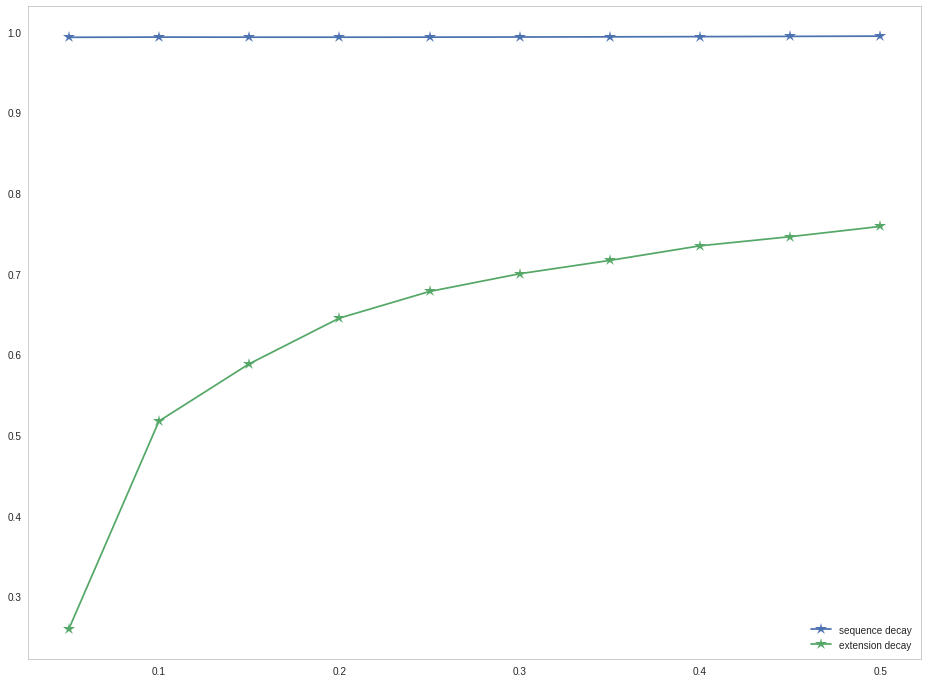

In [217]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_z_pre_vector, tau_z_sequence_decay, '*-', markersize=13, label='sequence decay')
ax.plot(tau_z_pre_vector, tau_z_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')

ax.legend();

## tau_p

In [63]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

tau_p_vector = np.arange(0.1, 10.1, 0.5)

In [64]:
tau_p_intensity = []
tau_p_sequence_decay = []
tau_p_extension = []
tau_p_extension_decay = []
tau_p_inhibition = []
tau_p_inhibition_std = []

for tau_p in tau_p_vector:
    print(tau_p)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre, tau_p=tau_p)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol, verbose=False)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(tau_p_intensity, intensity, tau_p_sequence_decay, sequence_decay, tau_p_extension, 
                 extension, tau_p_extension_decay, extension_decay, tau_p_inhibition, inhibition,
                 tau_p_inhibition_std, inhibition_std)
    

0.1
0.6
1.1
1.6
2.1
2.6
3.1
3.6
4.1
4.6
5.1
5.6
6.1
6.6
7.1
7.6
8.1
8.6
9.1
9.6


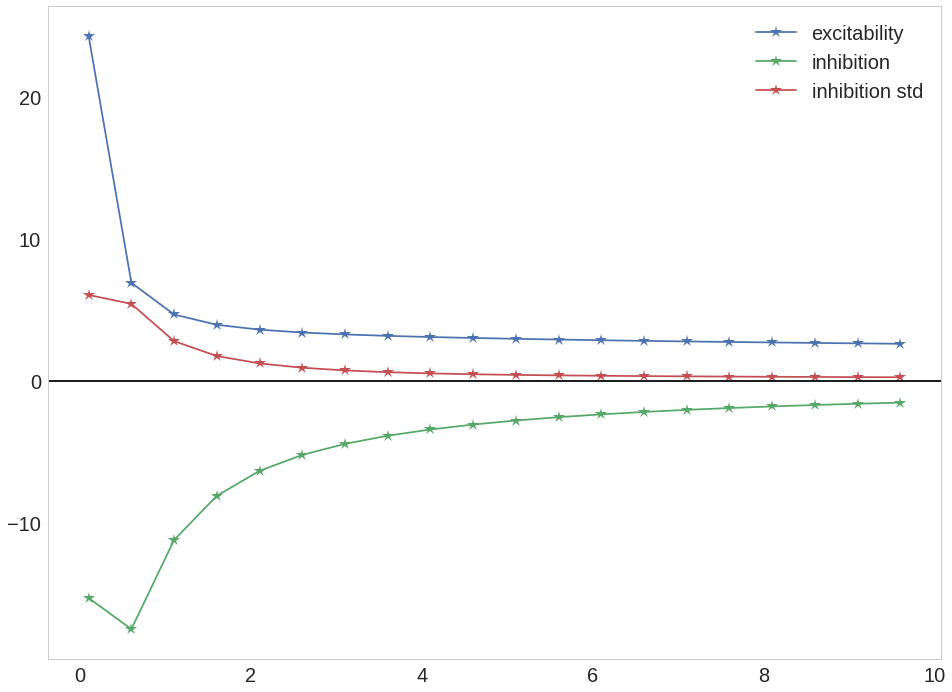

In [65]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_p_vector, tau_p_intensity, '*-', markersize=13, label='excitability')
ax.plot(tau_p_vector, tau_p_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(tau_p_vector, tau_p_inhibition_std, '*-', markersize=13, label='inhibition std')
ax.axhline(0, color='k')

ax.legend();

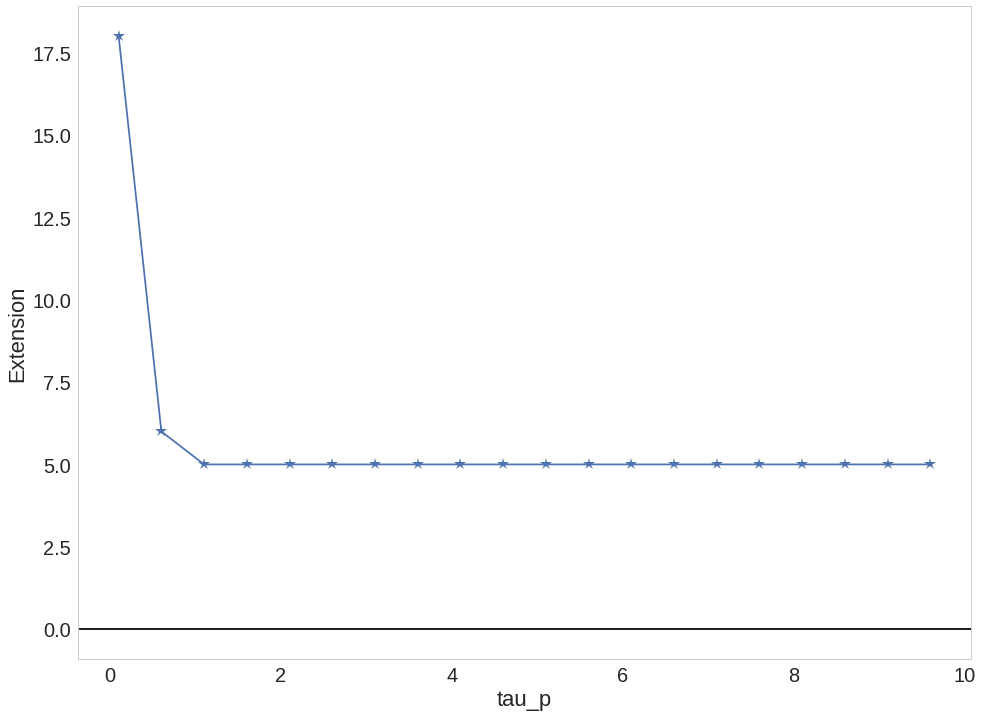

In [67]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_p_vector, tau_p_extension, '*-', markersize=13, label='extension')

ax.set_xlabel('tau_p')
ax.set_ylabel('Extension')

ax.axhline(0, color='k');

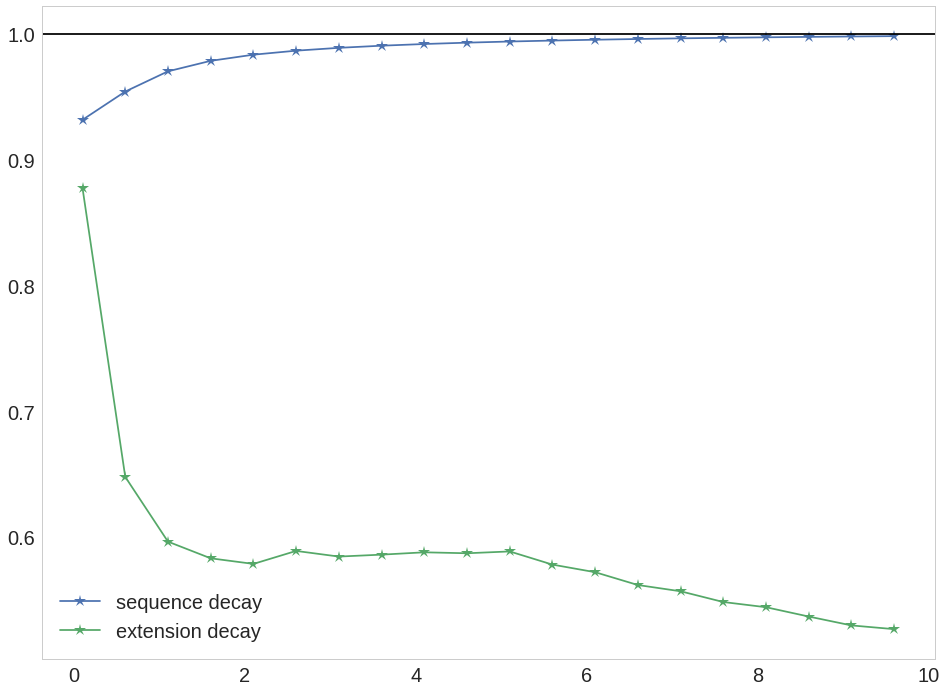

In [68]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_p_vector, tau_p_sequence_decay, '*-', markersize=13, label='sequence decay')
ax.plot(tau_p_vector, tau_p_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')

ax.legend();

## Tau_a

In [36]:
tolerance = 5

In [40]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

n = 5
T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

tau_a_vector = np.arange(1.0, 5.5, 0.500)

In [41]:
tau_a_intensity = []
tau_a_decay = []
tau_a_extension = []
tau_a_extension_decay = []
tau_a_inhibition = []
tau_a_inhibition_std = []

for tau_a in tau_a_vector:
    print(tau_a)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre, tau_a=tau_a)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol, verbose=False)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(tau_a_intensity, intensity, tau_a_decay, sequence_decay, tau_a_extension, 
                 extension, tau_a_extension_decay, extension_decay, tau_a_inhibition, inhibition,
                 tau_a_inhibition_std, inhibition_std)
    

1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0


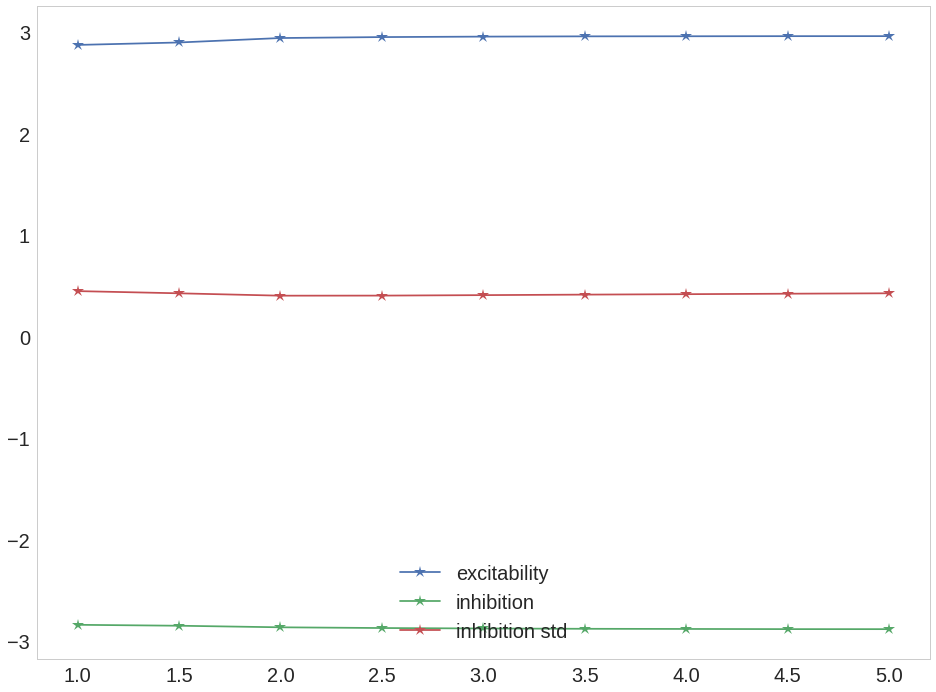

In [42]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_a_vector, tau_a_intensity, '*-', markersize=13, label='excitability')
ax.plot(tau_a_vector, tau_a_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(tau_a_vector, tau_a_inhibition_std, '*-', markersize=13, label='inhibition std')

ax.legend();

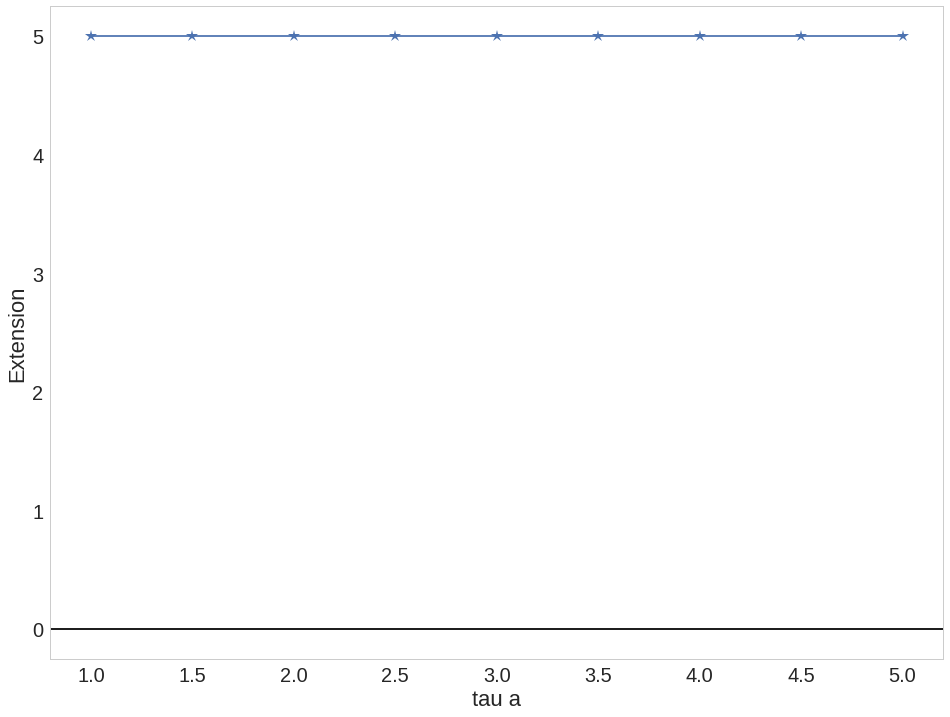

In [46]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_a_vector, tau_a_extension, '*-', markersize=13, label='extension')

ax.axhline(0, color='k')

ax.set_xlabel('tau a')
ax.set_ylabel('Extension');

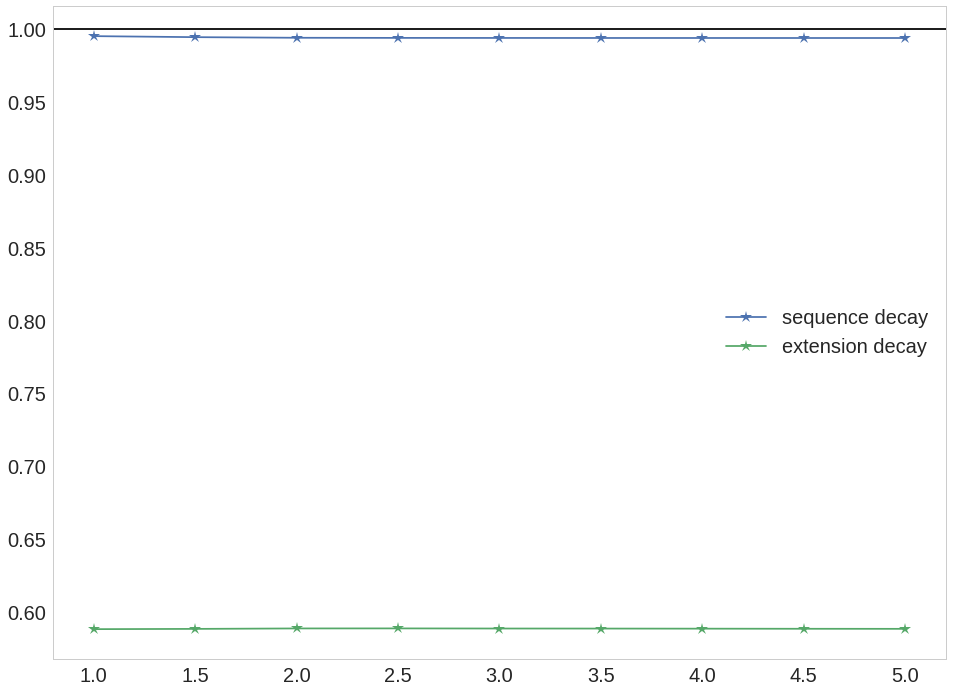

In [61]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_a_vector, tau_a_decay, '*-', markersize=13, label='sequence decay')
ax.plot(tau_a_vector, tau_a_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')

ax.legend();

## Numbef of patterns

In [52]:
tolerance = 5

In [55]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_a = 2.7
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

n = 5
T_cue = 0.100
T_recall = 10.0

n_patterns_vector = np.arange(15, 55, 5)

In [56]:
n_patterns_intensity = []
n_patterns_decay = []
n_patterns_extension = []
n_patterns_extension_decay = []
n_patterns_inhibition = []
n_patterns_inhibition_std = []

for n_patterns in n_patterns_vector:
    print(n_patterns)
    patterns_indexes = [i for i in range(n_patterns)]
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre, tau_a=tau_a)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol, verbose=False)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(n_patterns_intensity, intensity, n_patterns_decay, sequence_decay, n_patterns_extension, 
                 extension, n_patterns_extension_decay, extension_decay, n_patterns_inhibition, inhibition,
                 n_patterns_inhibition_std, inhibition_std)
    

15
20
25
30
35
40
45
50


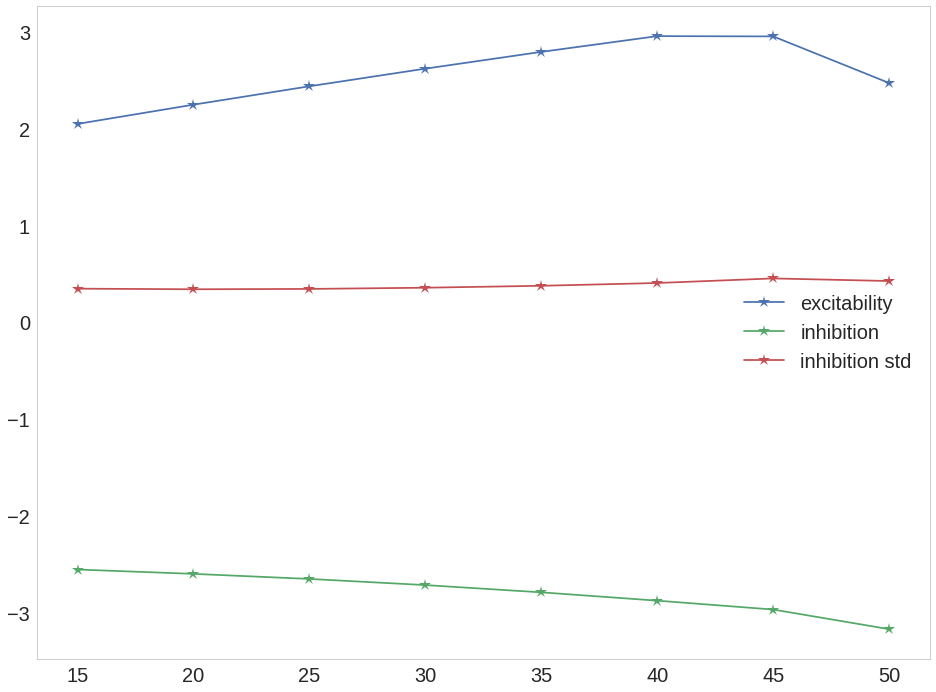

In [57]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(n_patterns_vector, n_patterns_intensity, '*-', markersize=13, label='excitability')
ax.plot(n_patterns_vector, n_patterns_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(n_patterns_vector, n_patterns_inhibition_std, '*-', markersize=13, label='inhibition std')

ax.legend();

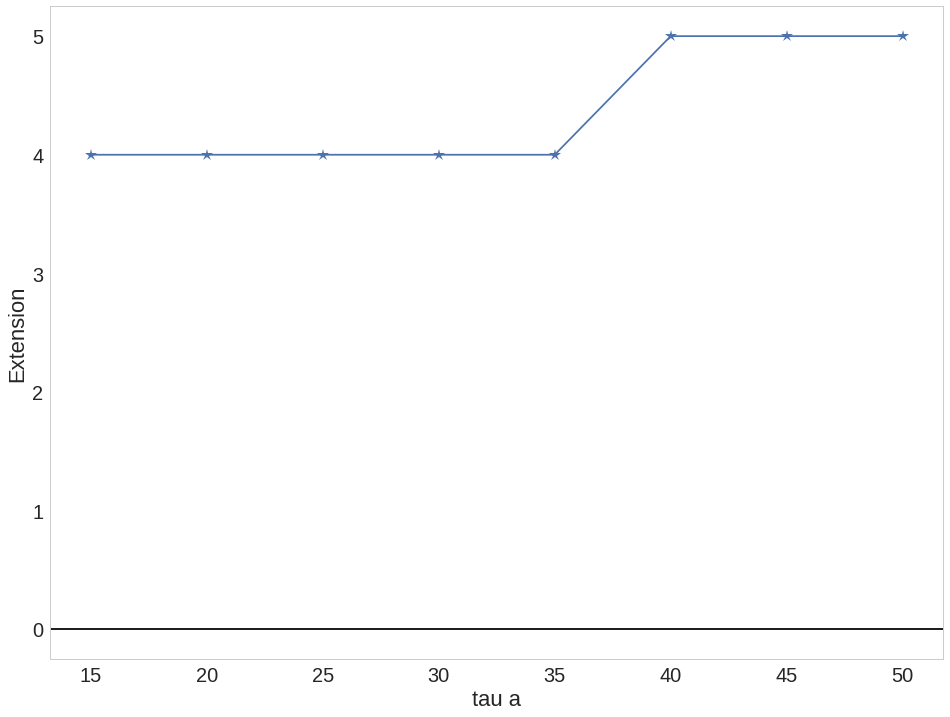

In [58]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(n_patterns_vector, n_patterns_extension, '*-', markersize=13, label='extension')

ax.axhline(0, color='k')

ax.set_xlabel('tau a')
ax.set_ylabel('Extension');

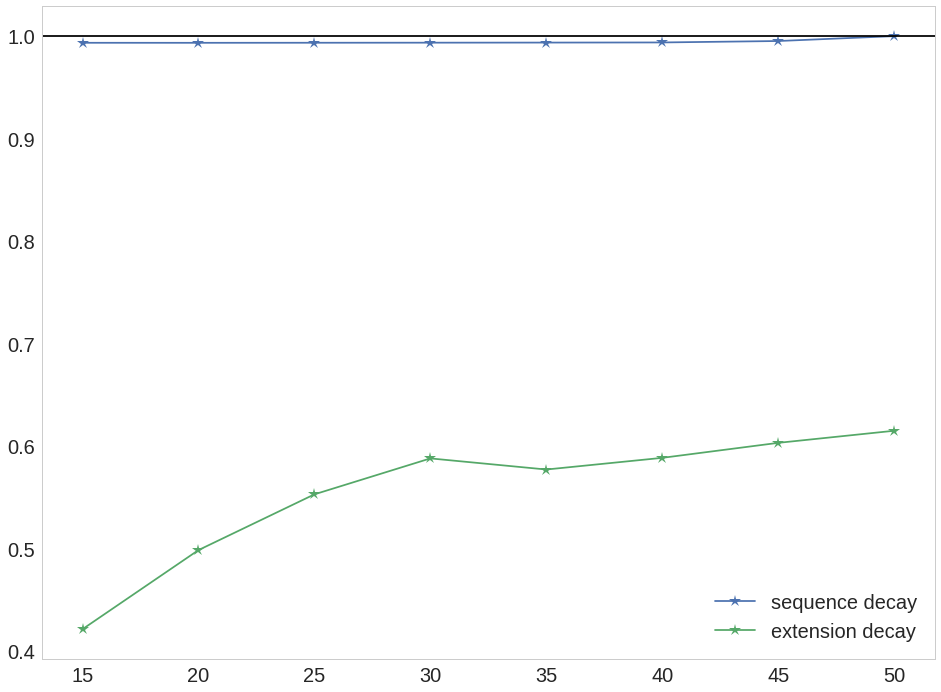

In [60]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(n_patterns_vector, n_patterns_decay, '*-', markersize=13, label='sequence decay')
ax.plot(n_patterns_vector, n_patterns_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')

ax.legend();

### Git machinery

In [124]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])